In [7]:
import numpy as np
import pandas as pd
import datetime as dt
from pandas_datareader import data
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import requests 
from bs4 import BeautifulSoup

URL = "https://markets.businessinsider.com/index/market-capitalization/nasdaq_100"
req = requests.get(URL)

soup = BeautifulSoup(req.content, 'html5lib')
temp = list()

for a in soup.findAll('a', href = True):
    if a['href'][0] == "/":
        if ('/stocks/' in a['href'] and a['href'].split('/')[2] != "" and len(a['href'].split('/')[2]) < 5):
            temp.append(a['href'].split('/')[2])

temp = temp[:20]

""" Extracting the top 20 stocks listed on NASDAQ today based on their 
    market-cap through Web-scraping from markets.businessinsider.com """

def read_data(tickers): #Function to get Closing Prices of a symbol from the past 100 trading days using Yahoo Finance
    
    df = pd.DataFrame()
    for ticker in tickers:
        df[ticker] = data.DataReader(ticker, 'yahoo', start = dt.date.today() - dt.timedelta(144))['Adj Close']
        
    return df.head(144)

fin_data = read_data(temp)
fin_data

,aapl,amzn,goog,fb,adbe,csco,asml,cost,amgn,chtr,avgo,amd,gild,fisv,atvi,amat,adp,ilmn,csx,adsk
Date,,,,,,,,,,,,,,,,,,,,
2020-03-13,277.219574,1785.000000,1219.729980,170.279999,335.500000,36.995052,255.655487,300.933685,200.741241,454.190002,227.956787,43.900002,70.125763,103.419998,58.654243,50.688164,143.657303,233.330002,57.735321,158.029999
2020-03-16,241.556122,1689.150024,1084.329956,146.009995,286.029999,33.132393,228.204483,281.928101,187.411453,389.109985,182.563980,38.709999,68.292084,86.180000,52.415272,40.369251,121.745834,211.020004,48.757153,148.080002
2020-03-17,252.177368,1807.839966,1119.800049,149.419998,311.809998,34.891720,237.139236,305.632812,206.402924,393.019989,194.174957,41.880001,73.862495,90.889999,55.793056,44.682083,128.635422,225.759995,54.068321,154.919998
2020-03-18,246.004074,1830.000000,1096.800049,146.960007,294.609985,36.483959,195.997559,306.140594,203.502548,381.519989,163.381042,39.119999,78.719261,80.949997,55.226784,39.024609,116.914177,209.199997,50.789944,141.820007
2020-03-19,244.119171,1880.930054,1115.290039,153.130005,307.510010,37.063850,212.951706,303.870667,197.423691,393.059998,189.250259,39.820000,77.856941,84.459999,53.776321,40.030602,116.685516,224.800003,54.815670,149.229996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-29,380.160004,3033.530029,1522.020020,233.289993,436.299988,46.709999,364.619995,325.440033,248.850006,566.419983,308.850006,76.089996,73.010002,101.370003,81.199997,63.250000,137.119995,385.279999,71.919998,238.610001
2020-07-30,384.760010,3051.879883,1531.449951,234.500000,438.880005,46.439999,362.730011,324.820007,246.139999,563.440002,312.100006,78.199997,72.330002,100.449997,81.699997,64.419998,132.889999,382.779999,70.239998,236.100006
2020-07-31,425.040009,3164.679932,1482.959961,253.669998,444.320007,47.099998,353.720001,325.529999,244.669998,580.000000,316.750000,77.430000,69.529999,99.790001,82.629997,64.330002,132.910004,382.160004,71.339996,236.429993


In [8]:
log_ret = np.log(fin_data/fin_data.shift(1)) #Normalizing the data for faster calculation
np.random.seed(42)

num_ports   = 6000
all_weights = np.zeros((num_ports, len(fin_data.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

""" Here we are trying to get the max sharpe ratio out of 6000 possible combinations. 
    The sharpe ratio is the average return earned in excess of the risk-free rate per unit of 
    volatility or total risk. Simply put, higher the Sharpe ratio, better should be our return of investment"""

for x in range(num_ports):

    weights = np.array(np.random.random(20))
    weights = weights/np.sum(weights)

    all_weights[x,:] = weights

    ret_arr[x] = np.sum( (log_ret.mean() * weights * 100))

    vol_arr[x] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 100, weights)))

    sharpe_arr[x] = ret_arr[x]/vol_arr[x]
    
print('Max Sharpe ratio : {}'.format(sharpe_arr.max()))
print('Location in array: {}'.format(sharpe_arr.argmax()))

Max Sharpe ratio : 1.5505426960136999
Location in array: 2286


In [9]:
max_sr_ret = ret_arr[sharpe_arr.argmax()]
max_sr_vol = vol_arr[sharpe_arr.argmax()]
all_weights[2286, :] #This shows us the weights of each portfolio at the max. Sharpe ratio

array([0.01692888, 0.12788618, 0.06737872, 0.05456542, 0.07951262,
       0.01466412, 0.04255096, 0.08778106, 0.01377838, 0.01861138,
       0.07026434, 0.08579679, 0.02573416, 0.00455293, 0.13188526,
       0.00378339, 0.00028239, 0.04449638, 0.0306128 , 0.07893385])

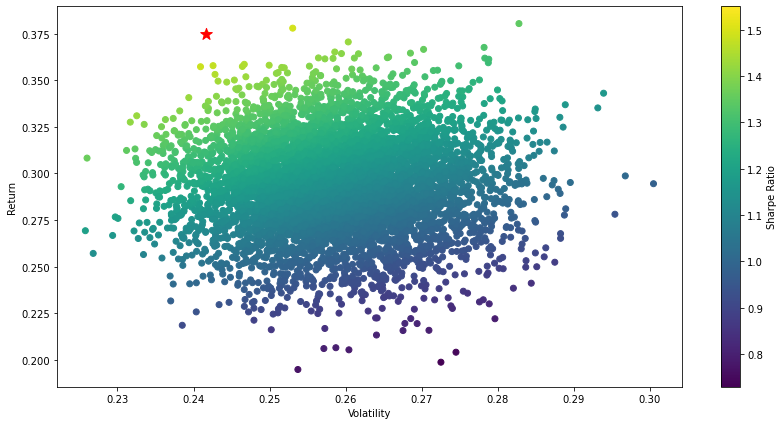

In [10]:
plt.figure(figsize = (14, 7))
plt.scatter(vol_arr, ret_arr, c = sharpe_arr, cmap = 'viridis')
plt.colorbar(label = 'Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(max_sr_vol, max_sr_ret, marker = '*', c = 'red', s = 150)
plt.show()

""" Portfolios that lie below the red star are sub-optimal because they do not 
    provide enough return for the level of risk. Potfolios that cluster to the 
    right of the red star are sub-optimal because they have a higher level 
    of risk for the defined rate of return. """

In [11]:
tickers = temp
weights = all_weights[2286, :]

dict = {}
for ticker, weight in zip(tickers, weights):
    dict[ticker] = weight
    
topten = Counter(dict).most_common(10)  #Obtaining the 10 greatest weights from array at 2286th iteration
 
for i in topten: 
    print(i[0]," :",i[1]," ")

atvi  : 0.13188526411361712  
amzn  : 0.12788617960732096  
cost  : 0.0877810570162111  
amd  : 0.08579679469535137  
adbe  : 0.07951261586184492  
adsk  : 0.07893385031164908  
avgo  : 0.07026433802867732  
goog  : 0.06737872253062231  
fb  : 0.054565421752550636  
ilmn  : 0.04449637882986931  


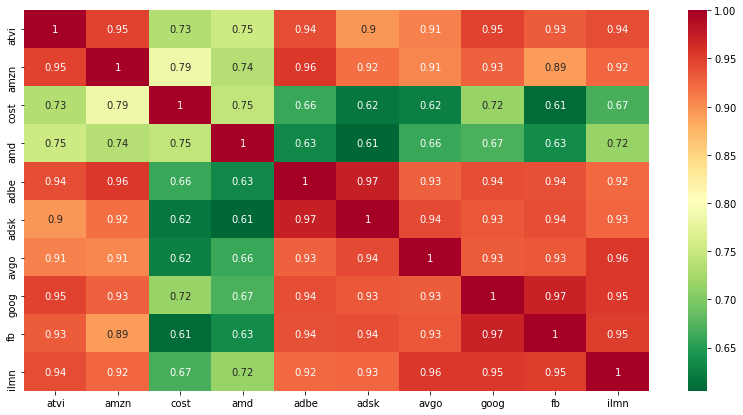

In [15]:
updatedtickers = list()

for i in topten:
    updatedtickers.append(i[0])
    
updated_data = read_data(updatedtickers)
    
corr_df = updated_data.corr(method = 'pearson') 
corr_df.head().reset_index()

""" Calculating the Pearson Coefficient between symbols. It varies from -1 to 1 
    and higher the coefficient, more is the correlation between the 2 symbols """

plt.figure(figsize = (14, 7))
sns.heatmap(corr_df, annot = True, cmap = 'RdYlGn_r') #Generating a Seaborn Heatmap displaying Pearson coefficients

In [33]:
""" Now let's try to find the 5 most uncorrelated stocks from this Heatmap. Right off, 
    cost & amd are relatively uncorrelated to many symbols and themselves too. They form 
    the first 2 out of 5 symbols for our portfolio. Atvi too has low correlation to cost 
    & amd, it's our 3rd symbol. Almost everything else is highly correlated so making sure 
    we don't select another symbol within the same industry, adbe and avgo complete our portfolio"""

res = {key: dict[key] for key in dict.keys() & {'cost', 'amd', 'adbe', 'atvi', 'avgo'}}

tot = 0
for i in res:
    tot += res[i]

for i in res:
    res[i] /= tot
    res[i] *= 100
    
res 
    #Updated portfolio with percentages mentioned to invest in 

{'atvi': 28.970486757894502,
 'avgo': 15.434567979167015,
 'adbe': 17.46608463343323,
 'cost': 19.282366130694626,
 'amd': 18.846494498810618}

Text(0, 0.5, 'daily returns')

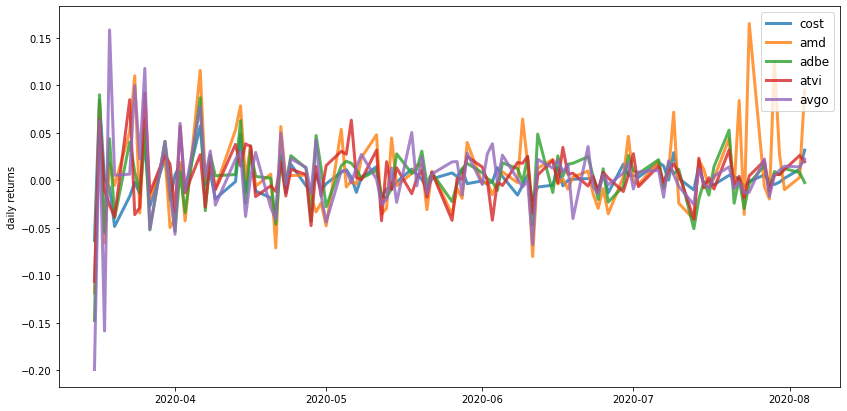

In [32]:
templist  = ['cost', 'amd', 'adbe', 'atvi', 'avgo']
temp_data = read_data(templist)
returns = temp_data.pct_change()

plt.figure(figsize = (14, 7))
for i in returns.columns.values:
    plt.plot(returns.index, returns[i], lw = 3, alpha = 0.8,label = i)
    
plt.legend(loc = 'upper right', fontsize = 12)
plt.ylabel('daily returns')

""" The daily percentage returns confirm our theory. Cost & amd's peaks 
    don't co-incide and to some extent sometimes differ with atvi's peaks 
    too. Adbe & avgo move relatively together due to the higher coefficient value (0.93) """